<span style="font-size: 5em">🦜</span>

# __LangGraph Essentials__
# Build A Workflow
<div style="display:flex; align-items:flex-start;">
  <img src="../assets/EmailWorkflow.png" width="600" style="margin-right:15px;"/>
</div>

## Setup

Load and/or check for needed environmental variables

In [1]:
from dotenv import load_dotenv
from env_utils import doublecheck_env

# Load environment variables from .env
load_dotenv()

# Check and print results
doublecheck_env("example.env")

OPENAI_API_KEY=****eJgA
LANGSMITH_API_KEY=****2eed
LANGSMITH_TRACING=true
LANGSMITH_PROJECT=****ject


In [2]:
import uuid
import os
from typing import Literal, TypedDict
from IPython.display import Image, display
from dotenv import load_dotenv

load_dotenv()

True

# Define state schemas

In [3]:
class EmailClassification(TypedDict):
    intent: Literal["question", "bug", "billing", "feature", "complex"]
    urgency: Literal["low", "medium", "high", "critical"]
    topic: str
    summary: str

class EmailAgentState(TypedDict):
    # Raw email data
    email_content: str
    sender_email: str
    email_id: str

    # Classification result
    classification: EmailClassification | None

    # Bug tracking
    ticket_id: str | None

    # Raw search results
    search_results: list[str] | None
    customer_history: dict | None

    # Generated content
    draft_response: str | None


# Define Nodes, Edges

In [4]:
from langchain_openai import ChatOpenAI
from langgraph.types import Command, interrupt
from langgraph.graph import END, START, StateGraph

def read_email(state: EmailAgentState) -> EmailAgentState:
    """Extract and parse email content"""
    pass

llm = ChatOpenAI(model="gpt-5-mini")

def classify_intent(state: EmailAgentState) -> EmailAgentState:
    """Use LLM to classify email intent and urgency, then route accordingly"""

    # Create structured LLM that returns EmailClassification dict
    structured_llm = llm.with_structured_output(EmailClassification)

    classification_prompt = f"""
    Analyze this customer email and classify it:

    Email: {state['email_content']}
    From: {state['sender_email']}

    Provide classification, including intent, urgency, topic, and summary
    """

    # Get structured response directly as a dict
    classification = structured_llm.invoke(classification_prompt)

    # Store classification as a single dict in state
    return {"classification": classification}

def search_documentation(state: EmailAgentState) -> EmailAgentState:
    """Search knowledge base for relevant information"""

    # Build search query from classification
    classification = state.get('classification', {})
    query = f"{classification.get('intent', '')} {classification.get('topic', '')}"

    try:
        # Implement search logic here
        search_results = [
            "--Search_result_1--",
            "--Search_result_2--",
            "--Search_result_3--"
        ]
    except SearchAPIError as e:
        # For recoverable search errors, store error and continue
        search_results = [f"Search temporarily unavailable: {str[e]}"]

    return {"search_results": search_results} # Raw search results or error

def bug_tracking(state: EmailAgentState) -> EmailAgentState:
    """Create or update bug tracking ticket"""

    # Create ticket in your bug tracking system
    ticket_id = f"BUG_{uuid.uuid4()}"

    return {"ticket_id": ticket_id}

def write_response(state: EmailAgentState) -> Command[Literal["human_review", "send_reply"]]:
    "Generate response using context and route based on quality"""

    classification = state.get('classification', {})

    # Format context from raw state data on demand
    context_sections = []

    if state.get('search_results'):
        # Format search results for the prompt
        formatted_docs = "\n".join([f"- {doc}" for doc in state['search_results']])
        context_sections.append(f"Relevant documentation:\n{formatted_docs}")

    if state.get('customer_history'):
        # Format customer data for the prompt
        context_sections.append(f"Customer tier: {state['customer_history'].get('tier', 'standard')}")

    # Build the prompt with formatted context
    draft_prompt = f"""
    Draft a response to this customer email:
    {state['email_content']}

    Email intent: {classification.get('intent', 'unkown')}
    Urgency level: {classification.get('urgency', 'medium')}

    {chr(10).join(context_sections)}

    Guidelines:
    - Be professional and helpful
    - Address their specific concern
    - Use the provided documentation when relevant
    - Be brief
    """

    response = llm.invoke(draft_prompt)

    # Determine if human review is needed based on urgency and intent
    needs_review = (
        classification.get('urgency') in ['high', 'critical'] or
        classification.get('intent') == 'complex'
    )

    # Route to the appropriate next node
    if needs_review:
        goto = "human_review"
        print("Needs approval")
    else:
        goto = "send_reply"

    return Command(
        update = {"draft_response": response.content},
        goto = goto
    )

def human_review(state: EmailAgentState) -> Command[Literal["send_reply", END]]:
    """Pause for human review using interrupt and route based on decision"""

    classification = state.get('classification', {})

    # Interrupt() must come first - any code before it will re-run on resume
    human_decision = interrupt({
        "email_id": state['email_id'],
        "original_email": state['email_content'],
        "draft_response": state.get('draft_response', ""),
        "urgency": classification.get('urgency'),
        "intent": classification.get('intent'),
        "action": "Please review and approve/edit this response"
    })

    # Now process the human's decision
    if human_decision.get("approved"):
        return Command(
            update = {"draft_response": human_decision.get("edited_response", state['draft_response'])},
            goto = "send_reply"
        )
    else:
        # Rejection means human will handle directly
        return Command(update = {}, goto = END)

def send_reply(state: EmailAgentState) -> EmailAgentState:
    """Send the email response"""
    # Integrate with a email service
    print(f"Sending reply: {state['draft_response'][:60]}...")
    return {}

# Build the graph

In [5]:
# Create the graph
builder = StateGraph(EmailAgentState)

# Add nodes
builder.add_node("read_email", read_email)
builder.add_node("classify_intent", classify_intent)
builder.add_node("search_documentation", search_documentation)
builder.add_node("bug_tracking", bug_tracking)
builder.add_node("write_response", write_response)
builder.add_node("human_review", human_review)
builder.add_node("send_reply", send_reply)

# Add edges
builder.add_edge(START, "read_email")
builder.add_edge("read_email", "classify_intent")
builder.add_edge("classify_intent", "search_documentation")
builder.add_edge("classify_intent", "bug_tracking")
builder.add_edge("search_documentation", "write_response")
builder.add_edge("bug_tracking", "write_response")
builder.add_edge("send_reply", END)

# Compile with checkpointer for persistence
from langgraph.checkpoint.memory import InMemorySaver
memory = InMemorySaver()
app = builder.compile(checkpointer = memory)

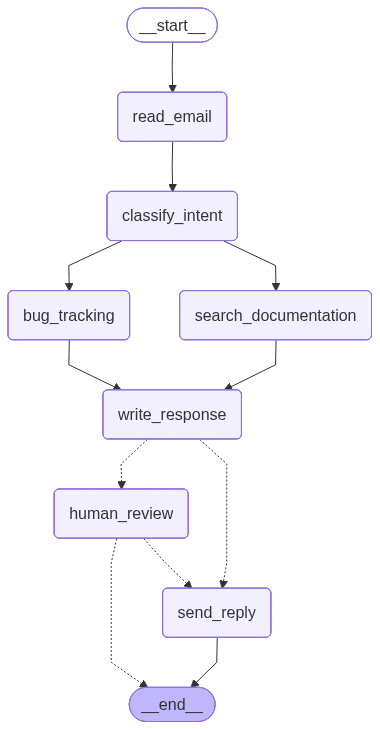

In [6]:
display(Image(app.get_graph().draw_mermaid_png()))

# Test

In [7]:
# Test with urgent billing issue
initial_state = {
    "email_content": "I was charged twice for my subscription! This is urgent!",
    "sender_email": "customer@example.com",
    "email_id": "email_123"
}

# Run with a thread_id for persistence
config = {"configurable": {"thread_id": "customer_123"}}
result = app.invoke(initial_state, config)

Needs approval


In [8]:
# The graph will pause at human_review
print(f"Draft ready for review: {result['draft_response'][:60]}...\n")

# Provide human input to resume
human_response = Command(
    resume = {
        "approved": True
    }
)

# Resume execution
final_result = app.invoke(human_response, config)
print("Email sent successfully!")

Draft ready for review: Subject: Urgent — We’ll investigate the duplicate charge

Hi...

Sending reply: Subject: Urgent — We’ll investigate the duplicate charge

Hi...
Email sent successfully!


In [9]:
email_content = [
    "I was charged two times for my subscription! This is urgent!",
    "I was wondering if this was available in blue?",
    "Can you tell me how long the sale is on?",
    "The tire won't stay on the car!",
    "My subscription is going to end in a few months, what is the new rate?"
]
needs_approval = []

for i, content in enumerate(email_content): 

    initial_state = {
        "email_content": content,
        "sender_email": "customer@example.com",
        "email_id": f"email_{i}",
    }
    print(f"{initial_state['email_id']}: ", end="")

    thread_id = uuid.uuid4()
    config =  {"configurable": {"thread_id": thread_id}}
    result = app.invoke(initial_state, config)
    if "__interrupt__" in result.keys():
        result['thread_id'] = thread_id
        needs_approval.append(result)

email_0: Needs approval
email_1: Sending reply: Hi —

Thanks for checking with us. Could you tell me which p...
email_2: Sending reply: Hi — thanks for asking. Which sale do you mean (sitewide, a ...
email_3: Needs approval
email_4: Sending reply: Hi [Customer Name],

Thanks for reaching out. To confirm the...


>LangSmith Trace - [Start-to-End](https://smith.langchain.com/public/3898d0d0-c934-4681-b325-7c4e1e88a826/r)  
>LangSmith Trace - [Interrupt](https://smith.langchain.com/public/c23a3aed-cfa8-42aa-8f1e-78f58941aecd/r)